***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [12]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,Target,url_char_%,url_char_&,url_char_+,url_char_-,url_char_.,url_char_/,url_char_0,url_char_1,url_char_2,url_char_3,url_char_4,url_char_5,url_char_6,url_char_7,url_char_8,url_char_9,url_char_:,url_char_=,url_char_?,url_char_A,url_char_B,url_char_C,url_char_D,url_char_E,url_char_F,url_char_G,url_char_H,url_char_I,url_char_J,url_char_K,url_char_L,url_char_M,url_char_N,url_char_O,url_char_P,url_char_Q,url_char_R,url_char_S,url_char_T,url_char_U,url_char_V,url_char_W,url_char_X,url_char_Y,url_char_Z,url_char__,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_q,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_contains_ip,url_contains_signin,url_contains_www,url_extension_.a,url_extension_.acc,url_extension_.ad,url_extension_.ag,url_extension_.ai,url_extension_.ap,url_extension_.app,url_extension_.asi,url_extension_.au,url_extension_.b,url_extension_.ban,url_extension_.bid,url_extension_.bik,url_extension_.br,url_extension_.c,url_extension_.ca,url_extension_.car,url_extension_.cat,url_extension_.cc,url_extension_.ce,url_extension_.cf,url_extension_.ch,url_extension_.cit,url_extension_.cl,url_extension_.class,url_extension_.cli,url_extension_.com,url_extension_.con,url_extension_.cur,url_extension_.d,url_extension_.dat,url_extension_.de,url_extension_.dec,url_extension_.dis,url_extension_.do,url_extension_.ex,url_extension_.exe,url_extension_.f,url_extension_.fgd,url_extension_.fi,url_extension_.fin,url_extension_.fm,url_extension_.fre,url_extension_.g,url_extension_.gg,url_extension_.gl,url_extension_.gra,url_extension_.h,url_extension_.ha,url_extension_.htm,url_extension_.html,url_extension_.i,url_extension_.icl,url_extension_.id,url_extension_.imp,url_extension_.inf,url_extension_.int,url_extension_.io,url_extension_.it,url_extension_.jpg,url_extension_.l,url_extension_.lid,url_extension_.lif,url_extension_.lin,url_extension_.log,url_extension_.m,url_extension_.man,url_extension_.me,url_extension_.med,url_extension_.mk,url_extension_.mm,url_extension_.mmo,url_extension_.mob,url_extension_.mon,url_extension_.mu,url_extension_.mus,url_extension_.net,url_extension_.new,url_extension_.ng,url_extension_.o,url_extension_.one,url_extension_.org,url_extension_.p,url_extension_.pa,url_extension_.par,url_extension_.ph,url_extension_.php,url_extension_.pip,url_extension_.pit,url_extension_.pk,url_extension_.pl,url_extension_.png,url_extension_.pp,url_extension_.pre,url_extension_.pri,url_extension_.pro,url_extension_.pw,url_extension_.r,url_extension_.ra,url_extension_.res,url_extension_.rev,url_extension_.ri,url_extension_.rs,url_extension_.ru,url_extension_.s,url_extension_.sc,url_extension_.sca,url_extension_.sci,url_extension_.sec,url_extension_.sf,url_extension_.sfl,url_extension_.sh,url_extension_.sha,url_extension_.sit,url_extension_.so,url_extension_.sp,url_extension_.spa,url_extension_.st,url_extension_.sta,url_extension_.sto,url_extension_.str,url_extension_.sup,url_extension_.t,url_extension_.tr,url_extension_.tv,url_extension_.upd,url_extension_.v,url_extension_.ver,url_extension_.vgr,url_extension_.vi,url_extension_.vic,url_extension_.vid,url_extension_.vo,url_extension_.w,url_extension_.web,url_extension_.win,url_extension_.wor,url_extension_.ws,url_extension_.x,url_extension_.xi,url_extension_.xx,url_extension_.xxx,url_extension_.xy,url_extension_.xyz,url_extension_.y,url_extension_.z,url_extension_.zi,url_extension_.zon,url_extension_0,url_extension_0.1,url_extension_0.8,url_extension_endswith_.a,url_extension_endswith_.acc,url_extension_endswith_.ad,url_extension_endswith_.ag,url_extension_endswith_.ai,url_extension_endswith_.ap,url_extension_endswith_.app,url_extension_endswith_.asi,url_extension_endswith_.au,url_extension_endswith_.b,url_extension_endswith_.ban,url_extension_endswith_.bid,url_extension_endswith_.bik,url_extension_ends

Shape of our dataset: (46771, 4194)


#### Let us analyze the balance of classes

In [13]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [14]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

url_contains_ip
url_extension_endswith_.a
url_extension_endswith_.acc
url_extension_endswith_.ap
url_extension_endswith_.asi
url_extension_endswith_.b
url_extension_endswith_.ban
url_extension_endswith_.bik
url_extension_endswith_.c
url_extension_endswith_.car
url_extension_endswith_.ce
url_extension_endswith_.cit
url_extension_endswith_.cli
url_extension_endswith_.con
url_extension_endswith_.cur
url_extension_endswith_.d
url_extension_endswith_.dec
url_extension_endswith_.dis
url_extension_endswith_.ex
url_extension_endswith_.f
url_extension_endswith_.fgd
url_extension_endswith_.fin
url_extension_endswith_.fre
url_extension_endswith_.g
url_extension_endswith_.gra
url_extension_endswith_.h
url_extension_endswith_.ha
url_extension_endswith_.i
url_extension_endswith_.icl
url_extension_endswith_.imp
url_extension_endswith_.inf
url_extension_endswith_.l
url_extension_endswith_.lid
url_extension_endswith_.lif
url_extension_endswith_.lin
url_extension_endswith_.log
url_extension_endswith_.m


In [15]:
ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

In [16]:
# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


#### Check for missing data

In [19]:
df.isnull().sum()

Target                         0
url_char_%                     0
url_char_&                     0
url_char_+                     0
url_char_-                     0
url_char_.                     0
url_char_/                     0
url_char_0                     0
url_char_1                     0
url_char_2                     0
url_char_3                     0
url_char_4                     0
url_char_5                     0
url_char_6                     0
url_char_7                     0
url_char_8                     0
url_char_9                     0
url_char_:                     0
url_char_=                     0
url_char_?                     0
url_char_A                     0
url_char_B                     0
url_char_C                     0
url_char_D                     0
url_char_E                     0
url_char_F                     0
url_char_G                     0
url_char_H                     0
url_char_I                     0
url_char_J                     0
url_char_K

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [20]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

3845 columns have more than 95% same values


In [21]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [23]:
columns=col_values[col_values['95_%_same_values']==False].index.values
col_values['95_%_same_values'].value_counts()

True     3845
False      46
Name: 95_%_same_values, dtype: int64

In [26]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])

Columns which are of type object: url_host    object
dtype: object


#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [29]:
columns=columns.tolist()

In [30]:
columns.remove('url_host')

In [31]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
url_tld_COM,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_tld_CO,-0.113462,8.344670e-134,-23.566296,3.026045e-119
url_extension_.c,-0.089428,1.169499e-83,-17.580858,5.011945e-68
url_tld_NE,-0.050163,1.886494e-27,-14.060359,1.447724e-44
url_extension_.i,-0.005769,2.122020e-01,-1.243880,2.135748e-01
url_char_m,-0.000765,8.685861e-01,-0.133716,8.936303e-01
url_char_o,0.074650,8.715169e-59,12.338724,1.155801e-34
url_char_j,0.116675,1.984745e-141,16.725416,1.082992e-61



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_endswith_.com,1657.0998,0.0,0.1882
url_extension_.net,138.8931,0.0,0.0545
url_tld_NET,138.8931,0.0,0.0545


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [33]:
print("Features we will be using:")
columns=num_stats_js[0:50].index.values.tolist() + cat_stats_js[0:50].index.values.tolist()
# columns=columns+['Target']
display(columns)

Features we will be using:


['url_tld_COM',
 'url_extension_.com',
 'url_tld_CO',
 'url_extension_.c',
 'url_tld_NE',
 'url_extension_.i',
 'url_char_m',
 'url_char_o',
 'url_char_j',
 'url_char_v',
 'url_char_c',
 'url_char_g',
 'url_char_-',
 'url_char_k',
 'url_char_r',
 'url_char_d',
 'url_words_with_length_8',
 'url_char_p',
 'url_char_h',
 'url_words_with_length_5',
 'url_char_f',
 'url_char_t',
 'url_words_with_length_6',
 'url_char_a',
 'url_char_b',
 'url_char_x',
 'url_char_u',
 'url_words_with_length_7',
 'url_char_n',
 'url_tlds',
 'url_char_l',
 'url_char_s',
 'url_char_e',
 'url_char_y',
 'url_char_z',
 'url_words_with_length_4',
 'url_char_i',
 'url_length',
 'url_char_w',
 'url_extensions',
 'url_char_.',
 'url_extension_endswith_.com',
 'url_extension_.net',
 'url_tld_NET']

In [34]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [35]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [36]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [37]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.966057301689
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31812    81    31893
True        1189  4334     5523
__all__    33001  4415    37416

Accuracy of the KNN model for twst data is: 0.954676643506
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7956    28     7984
True         396   975     1371
__all__     8352  1003     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.953736369468
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31483   410    31893
True        1321  4202     5523
__all__    32804  4612    37416

Accuracy of the Logistic Regression model for twst data is: 0.95189738108
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7892    92     7984
True         358  1013     1371
__all__     8250  1105     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.995857387214
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31888     5    31893
True         150  5373     5523
__all__    32038  5378    37416

Accuracy of the Random Forest Classifier for twst data is: 0.965900587921
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7940    44     7984
True         275  1096     1371
__all__     8215  1140     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.947001282874
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31415   478    31893
True        1505  4018     5523
__all__    32920  4496    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.943452699091
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7864   120     7984
True         409   962     1371
__all__     8273  1082     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.963144109472
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31583   310    31893
True        1069  4454     5523
__all__    32652  4764    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.957028327098
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7899    85     7984
True         317  1054     1371
__all__     8216  1139     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999973273466
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31893     0    31893
True           1  5522     5523
__all__    31894  5522    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.966221272047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7942    42     7984
True         274  1097     1371
__all__     8216  1139     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.995109044259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31882    11    31893
True         172  5351     5523
__all__    32054  5362    37416

Accuracy of the Bagging model for twst data is: 0.964938535542
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7925    59     7984
True         269  1102     1371
__all__     8194  1161     9355



Neural Network-1
The accuracy of the model on training data is: 0.996124652555


Predicted  False  True  __all__
Actual                         
False      31861    32    31893
True         113  5410     5523
__all__    31974  5442    37416

The accuracy of the model on test data is: 0.954569748797


Predicted  False  True  __all__
Actual                         
False       7828   156     7984
True         269  1102     1371
__all__     8097  1258     9355

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [38]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [39]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.966057,4334.0,31812.0,81.0,1189.0,0.002540,0.215282
LogisticRegression,0.953736,4202.0,31483.0,410.0,1321.0,0.012855,0.239182
RandomForestClassifier,0.995857,5373.0,31888.0,5.0,150.0,0.000157,0.027159
AdaBoostClassifier,0.947001,4018.0,31415.0,478.0,1505.0,0.014988,0.272497
GradientBoostingClassifier,0.963144,4454.0,31583.0,310.0,1069.0,0.009720,0.193554
ExtraTreeClassifier,0.999973,5522.0,31893.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.995109,5351.0,31882.0,11.0,172.0,0.000345,0.031142
Neural Network-1,0.996125,5410.0,31861.0,32.0,113.0,0.001003,0.020460


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.954677,975.0,7956.0,28.0,396.0,0.003507,0.288840,0.853826
LogisticRegression,0.951897,1013.0,7892.0,92.0,358.0,0.011523,0.261123,0.863677
RandomForestClassifier,0.965901,1096.0,7940.0,44.0,275.0,0.005511,0.200584,0.896953
AdaBoostClassifier,0.943453,962.0,7864.0,120.0,409.0,0.015030,0.298322,0.843324
GradientBoostingClassifier,0.957028,1054.0,7899.0,85.0,317.0,0.010646,0.231218,0.879068
ExtraTreeClassifier,0.966221,1097.0,7942.0,42.0,274.0,0.005261,0.199854,0.897443
BaggingClassifier,0.964939,1102.0,7925.0,59.0,269.0,0.007390,0.196207,0.898202
Neural Network-1,0.954570,1102.0,7828.0,156.0,269.0,0.019539,0.196207,0.898202


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [40]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [41]:
df.reset_index(inplace=True)


columns.append('domain')

df_min=df[columns]

In [42]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 46771, Columns: 45]
  Relationships:
    No relationships

In [43]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 3828 features
EntitySet scattered to workers in 7.538 seconds
Elapsed: 00:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [44]:
feature_matrix_sessions.head()

,url_tld_COM,url_extension_.com,url_tld_CO,url_extension_.c,url_tld_NE,url_extension_.i,url_char_m,url_char_o,url_char_j,url_char_v,url_char_c,url_char_g,url_char_-,url_char_k,url_char_r,url_char_d,url_words_with_length_8,url_char_p,url_char_h,url_words_with_length_5,url_char_f,url_char_t,url_words_with_length_6,url_char_a,url_char_b,url_char_x,url_char_u,url_words_with_length_7,url_char_n,url_tlds,url_char_l,url_char_s,url_char_e,url_char_y,url_char_z,url_words_with_length_4,url_char_i,url_length,url_char_w,url_extensions,url_char_.,url_extension_endswith_.com,url_extension_.net,url_tld_NET,url_char_l + url_char_o,url_char_c + url_char_y,url_char_i + url_char_y,url_char_l + url_char_u,url_char_h + url_char_u,url_char_l + url_extension_endswith_.com,url_char_r + url_tld_NE,url_char_e + url_char_m,url_char_f + url_length,url_char_k + url_extension_.net,url_char_h + url_words_with_length_5,url_char_- + url_char_l,url_char_. + url_char_l,url_char_a + url_words_with_length_8,url_char_e + url_char_o,url_char_j + url_words_with_length_6,url_char_b + url_char_p,url_char_u + url_tld_NET,url_char_- + url_words_with_length_7,url_char_x + url_words_with_length_8,url_char_n + url_extension_.i,url_char_j + url_char_p,url_extension_.i + url_tld_CO,url_char_e + url_char_p,url_char_l + url_extension_.i,url_char_i + url_words_with_length_6,url_char_w + url_tld_CO,url_char_n + url_tld_NE,url_extension_endswith_.com + url_words_with_length_4,url_tld_COM + url_words_with_length_7,url_char_t + url_tld_CO,url_char_- + url_words_with_length_6,url_char_z + url_extension_.c,url_tld_NET + url_words_with_length_8,url_char_m + url_words_with_length_5,url_char_d + url_char_n,url_char_y + url_tld_NET,url_char_h + url_char_x,url_char_a + url_char_d,url_char_m + url_char_u,url_char_s + url_char_t,url_char_e + url_char_k,url_char_g + url_char_r,url_char_- + url_char_r,url_char_j + url_words_with_length_4,url_char_j + url_char_k,url_char_f + url_extension_.com,url_char_b + url_char_k,url_extension_.c + url_extension_.com,url_char_v + url_extensions,url_char_i + url_char_m,url_char_g + url_char_u,url_char_t + url_tld_NE,url_char_z + url_extension_.com,url_char_h + url_words_with_length_4,url_char_k + url_words_with_length_7,url_tld_NE + url_words_with_length_4,url_tld_COM + url_tld_NE,url_char_z + url_tld_COM,url_char_j + url_length,url_char_. + url_char_v,url_char_f + url_char_z,url_char_- + url_char_w,url_char_a + url_char_w,url_char_b + url_char_e,url_char_p + url_char_x,url_char_d + url_tld_CO,url_char_k + url_tld_CO,url_char_c + url_char_v,url_char_e + url_tld_CO,url_char_b + url_char_s,url_char_r + url_char_z,url_char_r + url_extension_.c,url_char_u + url_length,url_char_j + url_char_t,url_char_. + url_char_f,url_char_e + url_char_u,url_char_s + url_words_with_length_8,url_char_g + url_char_l,url_char_f + url_tld_COM,url_char_t + url_char_x,url_char_e + url_words_with_length_5,url_char_l + url_tlds,url_char_k + url_extension_.i,url_char_n + url_char_s,url_char_j + url_tld_COM,url_char_y + url_words_with_length_6,url_extension_.c + url_length,url_char_f + url_char_w,url_char_h + url_tld_NET,url_char_n + url_extension_.net,url_char_t + url_tld_NET,url_char_a + url_extensions,url_tld_CO + url_tld_COM,url_char_l + url_char_p,url_char_i + url_char_n,url_char_d + url_char_h,url_char_v + url_words_with_length_6,url_words_with_length_7 + url_words_with_length_8,url_char_e + url_extension_.i,url_char_e + url_char_l,url_char_b + url_tld_NE,url_char_- + url_words_with_length_8,url_char_g + url_extension_endswith_.com,url_char_r + url_char_y,url_char_x + url_words_with_length_7,url_char_k + url_extensions,url_char_a + url_char_l,url_length + url_words_with_length_7,url_words_with_length_4 + url_words_with_length_8,url_char_t + url_char_u,url_extension_.i + url_words_with_length_8,url_char_b + url_char_y,url_char_t + url_tlds,url_char_p + url_extensions,url_extensions + url_tld_CO,url_char_y + url_extension_endswith_.com,url_char_f + url_char_n,url_char_e + url_char_h

In [45]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [46]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [47]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [48]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [49]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [50]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [51]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [52]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 29)

In [53]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_. + url_char_w',
 'url_length + url_tlds',
 'url_extensions + url_length',
 'url_extension_endswith_.com / url_char_.',
 'url_extension_.c + url_length',
 'url_char_w + url_words_with_length_8',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_y',
 'url_char_w * url_extensions',
 'url_char_u + url_length',
 'url_char_s + url_length',
 'url_char_n + url_length',
 'url_char_m + url_length',
 'url_char_j + url_length',
 'url_char_h + url_length',
 'url_char_c + url_length',
 'url_char_b + url_extensions',
 'url_char_. + url_words_with_length_7',
 'url_char_. + url_tld_NE',
 'url_char_. + url_length',
 'url_char_. + url_extension_.i',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. + url_char_x',
 'url_char_. + url_char_j',
 'url_char_. + url_char_b',
 'url_char_.',
 'url_char_- + url_char_.']

In [54]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [55]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.961941415437
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31552   338    31890
True        1086  4440     5526
__all__    32638  4778    37416

Accuracy of the KNN model for twst data is: 0.953821485836
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7855   132     7987
True         300  1068     1368
__all__     8155  1200     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.937379730597
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31326   564    31890
True        1779  3747     5526
__all__    33105  4311    37416

Accuracy of the Logistic Regression model for twst data is: 0.941849278461
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7859   128     7987
True         416   952     1368
__all__     8275  1080     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.989950823177
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31850    40    31890
True         336  5190     5526
__all__    32186  5230    37416

Accuracy of the Random Forest Classifier for twst data is: 0.957776590059
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7875   112     7987
True         283  1085     1368
__all__     8158  1197     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.936043403891
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31300   590    31890
True        1803  3723     5526
__all__    33103  4313    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.938107963656
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7845   142     7987
True         437   931     1368
__all__     8282  1073     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.950662818046
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31339   551    31890
True        1295  4231     5526
__all__    32634  4782    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.950828433993
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7847   140     7987
True         320  1048     1368
__all__     8167  1188     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.994654693179
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31880    10    31890
True         190  5336     5526
__all__    32070  5346    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.958952431855
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7867   120     7987
True         264  1104     1368
__all__     8131  1224     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.990191361984
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31844    46    31890
True         321  5205     5526
__all__    32165  5251    37416

Accuracy of the Bagging model for twst data is: 0.954462854089
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7834   153     7987
True         273  1095     1368
__all__     8107  1248     9355



Neural Network-1
The accuracy of the model on training data is: 0.972926020954


Predicted  False  True  __all__
Actual                         
False      31759   131    31890
True         882  4644     5526
__all__    32641  4775    37416

The accuracy of the model on test data is: 0.961411010155


Predicted  False  True  __all__
Actual                         
False       7894    93     7987
True         268  1100     1368
__all__     8162  1193     9355

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [56]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [57]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.961941,4440.0,31552.0,338.0,1086.0,0.010599,0.196526
LogisticRegression,0.937380,3747.0,31326.0,564.0,1779.0,0.017686,0.321933
RandomForestClassifier,0.989951,5190.0,31850.0,40.0,336.0,0.001254,0.060803
AdaBoostClassifier,0.936043,3723.0,31300.0,590.0,1803.0,0.018501,0.326276
GradientBoostingClassifier,0.950663,4231.0,31339.0,551.0,1295.0,0.017278,0.234347
ExtraTreeClassifier,0.994655,5336.0,31880.0,10.0,190.0,0.000314,0.034383
BaggingClassifier,0.990191,5205.0,31844.0,46.0,321.0,0.001442,0.058089
Neural Network-1,0.972926,4644.0,31759.0,131.0,882.0,0.004108,0.159609


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.953821,1068.0,7855.0,132.0,300.0,0.016527,0.219298,0.882087
LogisticRegression,0.941849,952.0,7859.0,128.0,416.0,0.016026,0.304094,0.839940
RandomForestClassifier,0.957777,1085.0,7875.0,112.0,283.0,0.014023,0.206871,0.889553
AdaBoostClassifier,0.938108,931.0,7845.0,142.0,437.0,0.017779,0.319444,0.831388
GradientBoostingClassifier,0.950828,1048.0,7847.0,140.0,320.0,0.017528,0.233918,0.874277
ExtraTreeClassifier,0.958952,1104.0,7867.0,120.0,264.0,0.015024,0.192982,0.895997
BaggingClassifier,0.954463,1095.0,7834.0,153.0,273.0,0.019156,0.199561,0.890641
Neural Network-1,0.961411,1100.0,7894.0,93.0,268.0,0.011644,0.195906,0.890641


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [58]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [68]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

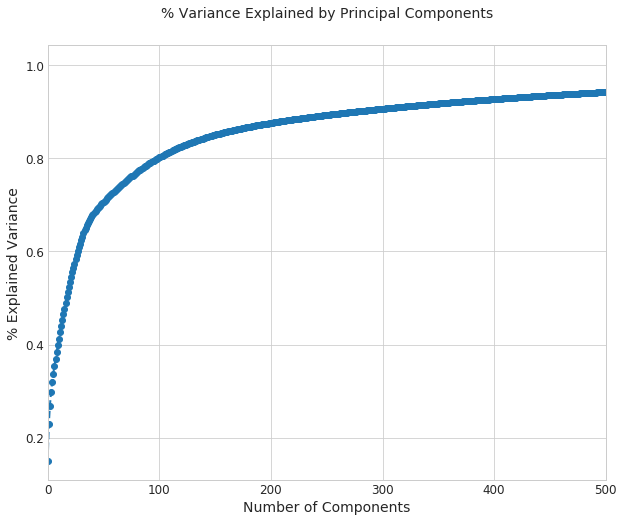

In [70]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,500])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [72]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0]

array([ 562,  563,  564, ..., 3825, 3826, 3827])

In [73]:
pca=PCA(n_components=562,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 562 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 562 components is: 0.94918921574


In [74]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [75]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [76]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,562).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.92952212957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31827    63    31890
True        2574  2952     5526
__all__    34401  3015    37416

Accuracy of the KNN model for twst data is: 0.913308391235
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7966    21     7987
True         790   578     1368
__all__     8756   599     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.967313448792
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31628   262    31890
True         961  4565     5526
__all__    32589  4827    37416

Accuracy of the Logistic Regression model for twst data is: 0.964190272582
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7893    94     7987
True         241  1127     1368
__all__     8134  1221     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.994521060509
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     6    31890
True         199  5327     5526
__all__    32083  5333    37416

Accuracy of the Random Forest Classifier for twst data is: 0.93276322822
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7901    86     7987
True         543   825     1368
__all__     8444   911     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.941869788326
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31346   544    31890
True        1631  3895     5526
__all__    32977  4439    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.938001068947
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7828   159     7987
True         421   947     1368
__all__     8249  1106     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.957184092367
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31622   268    31890
True        1334  4192     5526
__all__    32956  4460    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.950935328701
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7895    92     7987
True         367  1001     1368
__all__     8262  1093     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999973273466
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31890     0    31890
True           1  5525     5526
__all__    31891  5525    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.913415285943
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7921    66     7987
True         744   624     1368
__all__     8665   690     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.99387962369
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     6    31890
True         223  5303     5526
__all__    32107  5309    37416

Accuracy of the Bagging model for twst data is: 0.944200962052
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7860   127     7987
True         395   973     1368
__all__     8255  1100     9355



Neural Network-1
The accuracy of the model on training data is: 0.999679281591


Predicted  False  True  __all__
Actual                         
False      31883     7    31890
True           5  5521     5526
__all__    31888  5528    37416

The accuracy of the model on test data is: 0.960235168359


Predicted  False  True  __all__
Actual                         
False       7841   146     7987
True         226  1142     1368
__all__     8067  1288     9355

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [77]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [78]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.929522,2952.0,31827.0,63.0,2574.0,0.001976,0.465798
LogisticRegression,0.967313,4565.0,31628.0,262.0,961.0,0.008216,0.173905
RandomForestClassifier,0.994521,5327.0,31884.0,6.0,199.0,0.000188,0.036012
AdaBoostClassifier,0.941870,3895.0,31346.0,544.0,1631.0,0.017059,0.295150
GradientBoostingClassifier,0.957184,4192.0,31622.0,268.0,1334.0,0.008404,0.241404
ExtraTreeClassifier,0.999973,5525.0,31890.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993880,5303.0,31884.0,6.0,223.0,0.000188,0.040355
Neural Network-1,0.999679,5521.0,31883.0,7.0,5.0,0.000220,0.000905


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.913308,578.0,7966.0,21.0,790.0,0.002629,0.577485,0.709943
LogisticRegression,0.964190,1127.0,7893.0,94.0,241.0,0.011769,0.176170,0.906031
RandomForestClassifier,0.932763,825.0,7901.0,86.0,543.0,0.010767,0.396930,0.796151
AdaBoostClassifier,0.938001,947.0,7828.0,159.0,421.0,0.019907,0.307749,0.836172
GradientBoostingClassifier,0.950935,1001.0,7895.0,92.0,367.0,0.011519,0.268275,0.860103
ExtraTreeClassifier,0.913415,624.0,7921.0,66.0,744.0,0.008263,0.543860,0.723938
BaggingClassifier,0.944201,973.0,7860.0,127.0,395.0,0.015901,0.288743,0.847678
Neural Network-1,0.960235,1142.0,7841.0,146.0,226.0,0.018280,0.165205,0.847678


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [80]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,562).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [85]:
columns=num_stats_js[0:50].index.values.tolist() + cat_stats_js[0:50].index.values.tolist()
print('Features we will be using:\n')
columns=list(columns)
display(columns)

Features we will be using:



['url_tld_COM',
 'url_extension_.com',
 'url_tld_CO',
 'url_extension_.c',
 'url_tld_NE',
 'url_extension_.i',
 'url_char_m',
 'url_char_o',
 'url_char_j',
 'url_char_v',
 'url_char_c',
 'url_char_g',
 'url_char_-',
 'url_char_k',
 'url_char_r',
 'url_char_d',
 'url_words_with_length_8',
 'url_char_p',
 'url_char_h',
 'url_words_with_length_5',
 'url_char_f',
 'url_char_t',
 'url_words_with_length_6',
 'url_char_a',
 'url_char_b',
 'url_char_x',
 'url_char_u',
 'url_words_with_length_7',
 'url_char_n',
 'url_tlds',
 'url_char_l',
 'url_char_s',
 'url_char_e',
 'url_char_y',
 'url_char_z',
 'url_words_with_length_4',
 'url_char_i',
 'url_length',
 'url_char_w',
 'url_extensions',
 'url_char_.',
 'url_extension_endswith_.com',
 'url_extension_.net',
 'url_tld_NET']

In [86]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [87]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [88]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.979321481203
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30606   1287    31893
True          32  31861    31893
__all__    30638  33148    63786

Accuracy of the KNN model for twst data is: 0.923249599145
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7496   488     7984
True         230  1141     1371
__all__     7726  1629     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.905637600727
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29888   2005    31893
True        4014  27879    31893
__all__    33902  29884    63786

Accuracy of the Logistic Regression model for twst data is: 0.92282202031
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7467   517     7984
True         205  1166     1371
__all__     7672  1683     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.998432257862
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31886      7    31893
True          93  31800    31893
__all__    31979  31807    63786

Accuracy of the Random Forest Classifier for twst data is: 0.964510956708
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7917    67     7984
True         265  1106     1371
__all__     8182  1173     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.938826701784
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30390   1503    31893
True        2399  29494    31893
__all__    32789  30997    63786

Accuracy of the Ada Boost Classifier for twst data is: 0.930518439337
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7622   362     7984
True         288  1083     1371
__all__     7910  1445     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.965509672969
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31078    815    31893
True        1385  30508    31893
__all__    32463  31323    63786

Accuracy of the Gradient Boosting Classifier for twst data is: 0.948049171566
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7776   208     7984
True         278  1093     1371
__all__     8054  1301     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999984322579
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31893      0    31893
True           1  31892    31893
__all__    31894  31892    63786

Accuracy of the Extra Tree Classifier for twst data is: 0.965793693212
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7930    54     7984
True         266  1105     1371
__all__     8196  1159     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.997711096479
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31886      7    31893
True         139  31754    31893
__all__    32025  31761    63786

Accuracy of the Bagging model for twst data is: 0.963442009621
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7915    69     7984
True         273  1098     1371
__all__     8188  1167     9355



Neural Network-1
The accuracy of the model on training data is: 0.998118709435


Predicted  False   True  __all__
Actual                          
False      31868     25    31893
True          95  31798    31893
__all__    31963  31823    63786

The accuracy of the model on test data is: 0.95350080171


Predicted  False  True  __all__
Actual                         
False       7815   169     7984
True         266  1105     1371
__all__     8081  1274     9355

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [89]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [90]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.979321,31861.0,30606.0,1287.0,32.0,0.040354,0.001003
LogisticRegression,0.905638,27879.0,29888.0,2005.0,4014.0,0.062866,0.125858
RandomForestClassifier,0.998432,31800.0,31886.0,7.0,93.0,0.000219,0.002916
AdaBoostClassifier,0.938827,29494.0,30390.0,1503.0,2399.0,0.047126,0.075220
GradientBoostingClassifier,0.965510,30508.0,31078.0,815.0,1385.0,0.025554,0.043426
ExtraTreeClassifier,0.999984,31892.0,31893.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.997711,31754.0,31886.0,7.0,139.0,0.000219,0.004358
Neural Network-1,0.998119,31798.0,31868.0,25.0,95.0,0.000784,0.002979


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.923250,1141.0,7496.0,488.0,230.0,0.061122,0.167761,0.885558
LogisticRegression,0.922822,1166.0,7467.0,517.0,205.0,0.064755,0.149526,0.892860
RandomForestClassifier,0.964511,1106.0,7917.0,67.0,265.0,0.008392,0.193290,0.899159
AdaBoostClassifier,0.930518,1083.0,7622.0,362.0,288.0,0.045341,0.210066,0.872297
GradientBoostingClassifier,0.948049,1093.0,7776.0,208.0,278.0,0.026052,0.202772,0.885588
ExtraTreeClassifier,0.965794,1105.0,7930.0,54.0,266.0,0.006764,0.194019,0.899609
BaggingClassifier,0.963442,1098.0,7915.0,69.0,273.0,0.008642,0.199125,0.896116
Neural Network-1,0.953501,1105.0,7815.0,169.0,266.0,0.021167,0.194019,0.896116


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [91]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [92]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (13788, 3892)


,Target,url_char_%,url_char_&,url_char_+,url_char_-,url_char_.,url_char_/,url_char_0,url_char_1,url_char_2,url_char_3,url_char_4,url_char_5,url_char_6,url_char_7,url_char_8,url_char_9,url_char_:,url_char_=,url_char_?,url_char_A,url_char_B,url_char_C,url_char_D,url_char_E,url_char_F,url_char_G,url_char_H,url_char_I,url_char_J,url_char_K,url_char_L,url_char_M,url_char_N,url_char_O,url_char_P,url_char_Q,url_char_R,url_char_S,url_char_T,url_char_U,url_char_V,url_char_W,url_char_X,url_char_Y,url_char_Z,url_char__,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_q,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_contains_signin,url_contains_www,url_extension_.a,url_extension_.acc,url_extension_.ad,url_extension_.ag,url_extension_.ai,url_extension_.ap,url_extension_.app,url_extension_.asi,url_extension_.au,url_extension_.b,url_extension_.ban,url_extension_.bid,url_extension_.bik,url_extension_.br,url_extension_.c,url_extension_.ca,url_extension_.car,url_extension_.cat,url_extension_.cc,url_extension_.ce,url_extension_.cf,url_extension_.ch,url_extension_.cit,url_extension_.cl,url_extension_.class,url_extension_.cli,url_extension_.com,url_extension_.con,url_extension_.cur,url_extension_.d,url_extension_.dat,url_extension_.de,url_extension_.dec,url_extension_.dis,url_extension_.do,url_extension_.ex,url_extension_.exe,url_extension_.f,url_extension_.fgd,url_extension_.fi,url_extension_.fin,url_extension_.fm,url_extension_.fre,url_extension_.g,url_extension_.gg,url_extension_.gl,url_extension_.gra,url_extension_.h,url_extension_.ha,url_extension_.htm,url_extension_.html,url_extension_.i,url_extension_.icl,url_extension_.id,url_extension_.imp,url_extension_.inf,url_extension_.int,url_extension_.io,url_extension_.it,url_extension_.jpg,url_extension_.l,url_extension_.lid,url_extension_.lif,url_extension_.lin,url_extension_.log,url_extension_.m,url_extension_.man,url_extension_.me,url_extension_.med,url_extension_.mk,url_extension_.mm,url_extension_.mmo,url_extension_.mob,url_extension_.mon,url_extension_.mu,url_extension_.mus,url_extension_.net,url_extension_.new,url_extension_.ng,url_extension_.o,url_extension_.one,url_extension_.org,url_extension_.p,url_extension_.pa,url_extension_.par,url_extension_.ph,url_extension_.php,url_extension_.pip,url_extension_.pit,url_extension_.pk,url_extension_.pl,url_extension_.png,url_extension_.pp,url_extension_.pre,url_extension_.pri,url_extension_.pro,url_extension_.pw,url_extension_.r,url_extension_.ra,url_extension_.res,url_extension_.rev,url_extension_.ri,url_extension_.rs,url_extension_.ru,url_extension_.s,url_extension_.sc,url_extension_.sca,url_extension_.sci,url_extension_.sec,url_extension_.sf,url_extension_.sfl,url_extension_.sh,url_extension_.sha,url_extension_.sit,url_extension_.so,url_extension_.sp,url_extension_.spa,url_extension_.st,url_extension_.sta,url_extension_.sto,url_extension_.str,url_extension_.sup,url_extension_.t,url_extension_.tr,url_extension_.tv,url_extension_.upd,url_extension_.v,url_extension_.ver,url_extension_.vgr,url_extension_.vi,url_extension_.vic,url_extension_.vid,url_extension_.vo,url_extension_.w,url_extension_.web,url_extension_.win,url_extension_.wor,url_extension_.ws,url_extension_.x,url_extension_.xi,url_extension_.xx,url_extension_.xxx,url_extension_.xy,url_extension_.xyz,url_extension_.y,url_extension_.z,url_extension_.zi,url_extension_.zon,url_extension_0,url_extension_0.1,url_extension_0.8,url_extension_endswith_.ad,url_extension_endswith_.ag,url_extension_endswith_.ai,url_extension_endswith_.app,url_extension_endswith_.au,url_extension_endswith_.bid,url_extension_endswith_.br,url_extension_endswith_.ca,url_extension_endswith_.cat,url_extension_endswith_.cc,url_extension_endswith_.cf,url_extension_endswith_.ch,url_extension_endswith_.cl,url_extension_endswith_.class,url_e

In [93]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [94]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [95]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['url_tld_COM',
 'url_extension_.com',
 'url_tld_CO',
 'url_extension_.c',
 'url_tld_NE',
 'url_extension_.i',
 'url_char_m',
 'url_char_o',
 'url_char_j',
 'url_char_v',
 'url_char_c',
 'url_char_g',
 'url_char_-',
 'url_char_k',
 'url_char_r',
 'url_char_d',
 'url_words_with_length_8',
 'url_char_p',
 'url_char_h',
 'url_words_with_length_5',
 'url_char_f',
 'url_char_t',
 'url_words_with_length_6',
 'url_char_a',
 'url_char_b',
 'url_char_x',
 'url_char_u',
 'url_words_with_length_7',
 'url_char_n',
 'url_tlds',
 'url_char_l',
 'url_char_s',
 'url_char_e',
 'url_char_y',
 'url_char_z',
 'url_words_with_length_4',
 'url_char_i',
 'url_length',
 'url_char_w',
 'url_extensions',
 'url_char_.',
 'url_extension_endswith_.com',
 'url_extension_.net',
 'url_tld_NET']

In [96]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.915593834995
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5436    97     5533
True         834  4663     5497
__all__     6270  4760    11030

Accuracy of the KNN model for twst data is: 0.893038433648
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1322    39     1361
True         256  1141     1397
__all__     1578  1180     2758



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.903807796917
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5184   349     5533
True         712  4785     5497
__all__     5896  5134    11030

Accuracy of the Logistic Regression model for twst data is: 0.897026831037
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1271    90     1361
True         194  1203     1397
__all__     1465  1293     2758



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.991115140526
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5529     4     5533
True          94  5403     5497
__all__     5623  5407    11030

Accuracy of the Random Forest Classifier for twst data is: 0.918781725888
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1306    55     1361
True         169  1228     1397
__all__     1475  1283     2758



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.89601087942
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5098   435     5533
True         712  4785     5497
__all__     5810  5220    11030

Accuracy of the Ada Boost Classifier for twst data is: 0.892313270486
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1246   115     1361
True         182  1215     1397
__all__     1428  1330     2758



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.912239347235
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5260   273     5533
True         695  4802     5497
__all__     5955  5075    11030

Accuracy of the Gradient Boosting Classifier for twst data is: 0.903190717912
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1281    80     1361
True         187  1210     1397
__all__     1468  1290     2758



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5533     0     5533
True           0  5497     5497
__all__     5533  5497    11030

Accuracy of the Extra Tree Classifier for twst data is: 0.910804931109
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1292    69     1361
True         177  1220     1397
__all__     1469  1289     2758



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.990389845875
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5526     7     5533
True          99  5398     5497
__all__     5625  5405    11030

Accuracy of the Bagging model for twst data is: 0.909717186367
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1292    69     1361
True         180  1217     1397
__all__     1472  1286     2758



Neural Network-1
The accuracy of the model on training data is: 0.99401631913


Predicted  False  True  __all__
Actual                         
False       5508    25     5533
True          41  5456     5497
__all__     5549  5481    11030

The accuracy of the model on test data is: 0.89412617839


Predicted  False  True  __all__
Actual                         
False       1207   154     1361
True         138  1259     1397
__all__     1345  1413     2758

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [97]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [98]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.915594,4663.0,5436.0,97.0,834.0,0.017531,0.151719
LogisticRegression,0.903808,4785.0,5184.0,349.0,712.0,0.063076,0.129525
RandomForestClassifier,0.991115,5403.0,5529.0,4.0,94.0,0.000723,0.017100
AdaBoostClassifier,0.896011,4785.0,5098.0,435.0,712.0,0.078619,0.129525
GradientBoostingClassifier,0.912239,4802.0,5260.0,273.0,695.0,0.049340,0.126433
ExtraTreeClassifier,1.000000,5497.0,5533.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.990390,5398.0,5526.0,7.0,99.0,0.001265,0.018010
Neural Network-1,0.994016,5456.0,5508.0,25.0,41.0,0.004518,0.007459


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.893038,1141.0,1322.0,39.0,256.0,0.028655,0.183250,0.894047
LogisticRegression,0.897027,1203.0,1271.0,90.0,194.0,0.066128,0.138869,0.897502
RandomForestClassifier,0.918782,1228.0,1306.0,55.0,169.0,0.040411,0.120974,0.919308
AdaBoostClassifier,0.892313,1215.0,1246.0,115.0,182.0,0.084497,0.130279,0.892612
GradientBoostingClassifier,0.903191,1210.0,1281.0,80.0,187.0,0.058780,0.133858,0.903681
ExtraTreeClassifier,0.910805,1220.0,1292.0,69.0,177.0,0.050698,0.126700,0.911301
BaggingClassifier,0.909717,1217.0,1292.0,69.0,180.0,0.050698,0.128848,0.910227
Neural Network-1,0.894126,1259.0,1207.0,154.0,138.0,0.113152,0.098783,0.910227


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [99]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [100]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')